<h1 style="font-size:40px;"><center>Exercise III:<br> Image Classification using CNNs</center></h1>

Welcome to the *fourth* lab for Deep Learning!

In this lab an CNN network to classify rgb images. Image classification refers to classify classes from images. This labs *dataset* consist of multiple images where each image have a target label for classification.

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** writing we have prepared the last cell in this notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!

This lab logs metrics to **Tensorboard**, for instructions to install check the introduction pdf.

Good luck!

---

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to acces the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [4]:
# Torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# local modules
from torch.utils.data import DataLoader
from DL_labs.utils.dataset import ClassificationDataset
from DL_labs.utils import dataloader
from DL_labs.utils.model import Model
from config import flying_objects_config
from collections import OrderedDict
from DL_labs.utils import plot
import pprint
import torchmetrics
import pytorch_lightning as pl
import torchvision

from DL_labs.utils.progressbar import LitProgressBar

## Load config

In [5]:
cfg = flying_objects_config(False)
pprint.pprint(cfg)

{'BATCH_SIZE': 32,
 'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'GPU': -1,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 128,
 'IMAGE_WIDTH': 128,
 'NUM_CLASSES': 4,
 'NUM_WORKERS': 4,
 'SAVE_EVERY': 1,
 'TENSORBORD_DIR': 'logs/',
 'fineGrained': False,
 'testing_img_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_img_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_img_dir': '../data/FlyingObjectDataset_10K/validation'}


# Example Task
First we present an example task to get an idea of the implementation and how to structure the code.

## Example data
First load the dataloaders for three datasets; train, validation and test. Feel free to test different augmentations, more can be found at *https://pytorch.org/vision/stable/transforms.html*

Note that ToTensor and Rezise are required to reshape and transform the images correct. We do not want to apply augmentation to the test_transform that are applied on the validation and test dataloader.

In [6]:
## Augmentation

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),
])

In [7]:
train_dataloader = DataLoader(ClassificationDataset(cfg.training_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=train_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=True,
                        num_workers=cfg.NUM_WORKERS)
valid_dataloader = DataLoader(ClassificationDataset(cfg.validation_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

test_dataloader = DataLoader(ClassificationDataset(cfg.testing_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

print("Data batch generators are created!")

Data batch generators are created!


## Visualise data
To get an idea of the dataset we visualise the data. 

x (32, 3, 128, 128) torch.float32 0.0 1.0
y (32,) torch.int64 0 2


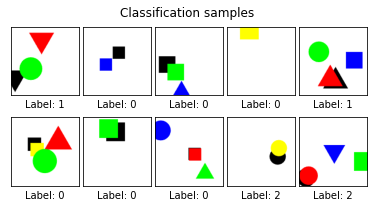

In [10]:
t_x, t_y = next(iter(train_dataloader))
print(f"x {tuple(t_x.shape)} {t_x.dtype} {t_x.min()} {t_x.max()}")
print(f"y {tuple(t_y.shape)} {t_y.dtype} {t_y.min()} {t_y.max()}")
plot.Classification.data(t_x, t_y, nimages=10,nrows=2)

In [11]:
if False: # Set to true to visualise statistics of the data
    plot.show_statistics(cfg.training_img_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
    plot.show_statistics(cfg.validation_img_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
    plot.show_statistics(cfg.testing_img_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")

## Create model
Here is an simple architecture to train our network.

In [12]:
class SimpleModel(nn.Module):
    def __init__(self,num_channels:int=4, num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(64*30*30, 64) # Calculated with the size
        self.fc2 = nn.Linear(64, num_classes)
        
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=0)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        # Set 1

        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        #out = self.batch(out)
 
        out = out.view(out.size(0), -1) # Flatten (batchsize, image size)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

## Config

In [14]:
# Train model
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(), # error function
    'max_epochs':5,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES, compute_on_step=False)
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.IoU(num_classes=cfg.NUM_CLASSES, compute_on_step=False)
    ],postfix="_Validation")
}

## Train

In [15]:
# Load model
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=cfg.GPU,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/stud/f/fremar16/miniconda3/envs/DL-Labs/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/home/stud/f/fremar16/miniconda3/envs/DL-Labs/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:895: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


## Test performance

In [ ]:
# Create iterable from the test dataset
iter_dataloader = iter(test_dataloader)

In [ ]:
# Take one batch from the test dataset and predict!
X, Y = next(iter_dataloader)
preds = torch.argmax(modelObj.predict_step(X,0,0),dim=1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
n_test = 10
df_result = pd.DataFrame({
    'Ground Truth': Y[:n_test],
    'Predicted label': preds[:n_test]})
display(df_result.T)

In [ ]:
plot.classification_results(X, preds)

# Exercises

## Task 1
Create an network architecture given in the function **create_model** of the class SegmenterDNNModel. 

**Hint:** You can add more convolution, max pooling layers etc. Batch normalization and dropout are other options to be considered. You can also try applying different activation functions.

## Hyperparameter tuning

## Augmentation
Test if data augmentation help

## Train model